# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
import time
from torchvision import datasets
from sklearn.model_selection import train_test_split

In [3]:
# If there is a GPU available, use it.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
BATCH_SIZE = 100

In [5]:
# Define transforms
## YOUR CODE HERE ##

# Data augmentation is done on training images
transform_training = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                                      ])

In [6]:
# No data augmentation is done on validation images and testing images
transform_validation_testing = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

### NOTE 
I decided that I wanted to have a validation data set that used a transformation that used no image augmentations, like the test data set<br>
Because the testing data set has 10,000 images, while the training data set has 50,000 images, I decided to split the training set into a training data set of 40,000 images and a validation data set of 10,000 images. <br>
My solution was to download two seperate, but identical, training sets. <br>
I then used **"from sklearn.model_selection import train_test_split"** to split the two training data sets with the same random state ensuring that the two training data sets were identically split. <br>
I was then able to transform the training data seperately from the validation and testing data. <br>
I think **"torch.utils.data.random_split"** would have did what I wanted, but is not available on UdaCity's current platform.

In [7]:
# Create training_validation set with augementations
## YOUR CODE HERE ##
testing_validation_dataset1 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_training)

Files already downloaded and verified


In [8]:
# Create training_validation set with no augementations
testing_validation_dataset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_validation_testing)

Files already downloaded and verified


In [9]:
# Create test set with no augementations
testing_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_validation_testing)

Files already downloaded and verified


In [10]:
start_time = time.time()
training_dataset, _ = train_test_split(testing_validation_dataset1, train_size=0.80, shuffle=False, random_state=7)

split_time = time.time()
print(f"The time for the first split is {split_time - start_time}")

_, validation_dataset = train_test_split(testing_validation_dataset2, train_size=0.80, shuffle=False, random_state=7)
print(f"The time for the second split is {time.time() - split_time}")

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The time for the first split is 30.89601445198059
The time for the second split is 10.75221300125122


In [11]:
print(f"The training_dataset is a {type(training_dataset)} with a length of {len(training_dataset)}")
print(f"The validation_dataset is a {type(validation_dataset)} with a length of {len(validation_dataset)}")
print(f"The testing_dataset is a {type(testing_dataset)} with a length of {len(testing_dataset)}")

The training_dataset is a <class 'list'> with a length of 40000
The validation_dataset is a <class 'list'> with a length of 10000
The testing_dataset is a <class 'torchvision.datasets.cifar.CIFAR10'> with a length of 10000


In [12]:
# Define training, validation, and testing dataloader
## YOUR CODE HERE ##
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=False)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [13]:
print(f"The training_loader is a {type(training_loader)}")
print(f"The validation_dataset is a {type(validation_loader)}")
print(f"The testing_dataset is a {type(testing_loader)}")

The training_loader is a <class 'torch.utils.data.dataloader.DataLoader'>
The validation_dataset is a <class 'torch.utils.data.dataloader.DataLoader'>
The testing_dataset is a <class 'torch.utils.data.dataloader.DataLoader'>


In [14]:
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Explore data
## YOUR CODE HERE ##
# Visualize some sample data
# obtain one batch of training images

images, labels = next(iter(training_loader))
print(f"The images are a {type(images)} with a shape of {images.shape}")
print(f"The labels are a {type(labels)} with a shape of {labels.shape}")

The images are a <class 'torch.Tensor'> with a shape of torch.Size([100, 3, 32, 32])
The labels are a <class 'torch.Tensor'> with a shape of torch.Size([100])


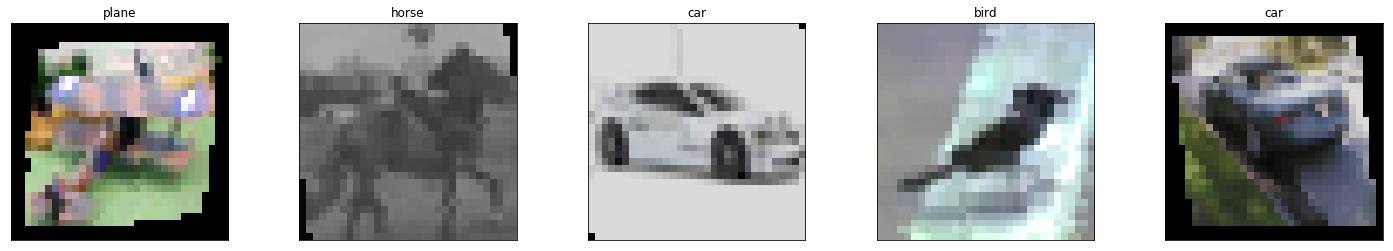

In [17]:
images = (images * 0.5) + 0.5
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for index in np.arange(5):
    ax = fig.add_subplot(1, 5, (index + 1), xticks=[], yticks=[])
    plt.imshow(np.transpose(images[index], (1, 2, 0)))
    ax.set_title(classes[labels[index]])

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [18]:
## YOUR CODE HERE ##
class CNN(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.dropout1 = nn.Dropout(0.50)
        self.dropout2 = nn.Dropout(0.50)
        self.dropout3 = nn.Dropout(0.50)
        
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)


    def forward(self, x):
        
        # conv layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.bn2(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))       
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = self.pool1(F.relu(self.conv6(x)))
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer        
        x = self.dropout2(x)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

In [19]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5)
  (dropout2): Dropout(p=0.5)
  (dropout3): Dropout(p=0.5)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_fe

In [20]:
images, labels = next(iter(training_loader))
images = images.to(device)
labels = labels.to(device)

In [21]:
# Get the class probabilities
probabilities = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for BATCH_SIZE examples
print(probabilities.shape)

torch.Size([100, 10])


In [22]:
top_probabilities, top_class = probabilities.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[ 8],
        [ 6],
        [ 8],
        [ 2],
        [ 0],
        [ 8],
        [ 7],
        [ 2],
        [ 8],
        [ 2]], device='cuda:0')


In [23]:
equals = top_class == labels.view(*top_class.shape)

In [24]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'The accuracy of the untrained model is {accuracy.item() * 100}%')

The accuracy of the untrained model is 9.000000357627869%


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [25]:
## YOUR CODE HERE ##
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # fine tuned the lr

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [26]:
## YOUR CODE HERE ##
# -*- coding: utf-8 -*-
"""
Created on Fri May 21 20:30:25 2021

@author: edperry
"""
epochs = 80
training_loss_list = []
training_accuracy_list = []

validation_loss_list = []
validation_accuracy_list = []

start_time, old_split_time = time.time(), time.time()

for epoch in range(epochs): 
    running_training_loss = 0.0
    training_accuracy = 0.0
    running_validation_loss = 0.0
    validation_accuracy = 0.0
  
    for training_images, training_labels in training_loader:
        
        training_images = training_images.to(device) 
        training_labels = training_labels.to(device)
        
        training_outputs = model(training_images) 
        training_loss = criterion(training_outputs, training_labels)
    
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
    
        _, preds = torch.max(training_outputs, 1)
        running_training_loss += training_loss.item()
        training_accuracy += torch.sum(preds == training_labels.data)
    else:
        with torch.no_grad():
            for validation_images, validation_labels in validation_loader:
                
                validation_images = validation_images.to(device)
                validation_labels = validation_labels.to(device)
                
                validation_outputs = model(validation_images)
                validation_loss = criterion(validation_outputs, validation_labels)
                    
                _, validation_preds = torch.max(validation_outputs, 1)
                running_validation_loss += validation_loss.item()
                validation_accuracy += torch.sum(validation_preds == validation_labels.data)

    training_epoch_loss = running_training_loss/len(training_loader)
    training_epoch_acc = training_accuracy.float()/ len(training_loader)
    
    training_loss_list.append(training_epoch_loss)
    training_accuracy_list.append(training_epoch_acc)
    
    validation_epoch_loss = running_validation_loss/len(validation_loader)
    validation_epoch_acc = validation_accuracy.float()/ len(validation_loader)
    
    validation_loss_list.append(validation_epoch_loss)
    validation_accuracy_list.append(validation_epoch_acc)

    print()
    print(f'The data for epoch {epoch} is:')
    
    print(f'The training loss is {training_epoch_loss}')
    print(f'The validation loss is {validation_epoch_loss}')
    
    print(f'The training accuracy is {training_epoch_acc.item()}')
    print(f'The validation accuracy is {validation_epoch_acc.item()}')                                      
    print()

    new_split_time = time.time()
        
    print(f"The time for epoch {epoch} is {new_split_time - old_split_time}")
    print(f"The total time is {new_split_time - start_time}")

    old_split_time = new_split_time


The data for epoch 0 is:
The training loss is 1.7245138639211655
The validation loss is 1.4521617913246154
The training accuracy is 34.787498474121094
The validation accuracy is 46.40999984741211

The time for epoch 0 is 46.440696716308594
The total time is 46.44069719314575

The data for epoch 1 is:
The training loss is 1.4043120861053466
The validation loss is 1.2588253635168076
The training accuracy is 48.744998931884766
The validation accuracy is 54.43000030517578

The time for epoch 1 is 46.27940607070923
The total time is 92.72010326385498

The data for epoch 2 is:
The training loss is 1.2522687362134457
The validation loss is 1.1297087490558624
The training accuracy is 54.94499969482422
The validation accuracy is 59.77000045776367

The time for epoch 2 is 46.24156928062439
The total time is 138.96167254447937

The data for epoch 3 is:
The training loss is 1.1268310061097144
The validation loss is 1.047107383608818
The training accuracy is 60.022499084472656
The validation accur

Plot the training loss (and validation loss/accuracy, if recorded).

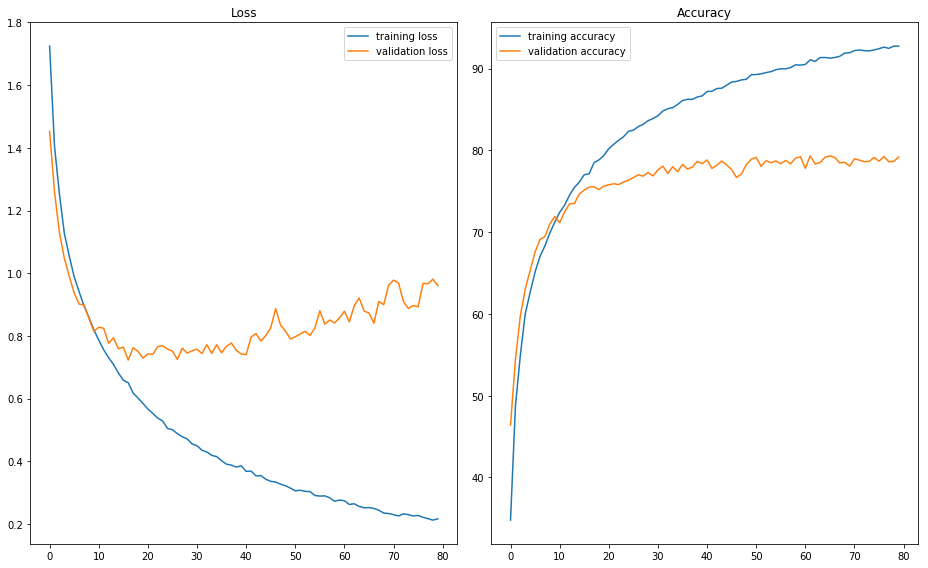

In [27]:
## YOUR CODE HERE ##
fig, axs = plt.subplots(1, 2, figsize=(13,8))

axs[0].plot(training_loss_list, label='training loss')
axs[0].plot(validation_loss_list, label='validation loss')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(training_accuracy_list, label='training accuracy')
axs[1].plot(validation_accuracy_list, label='validation accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig.tight_layout()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [28]:
## YOUR CODE HERE #
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for testing_images, testing_labels in testing_loader:
        
        testing_images = testing_images.to(device)
        testing_labels = testing_labels.to(device)
        
        testing_outputs = model(testing_images)

        _, predicted = torch.max(testing_outputs.data, 1)
        
        total_test_predictions += testing_labels.size(0)
        correct_test_predictions += (predicted == testing_labels).sum().item()

print(f'The accuracy of the model on {total_test_predictions} test images \
        is {(correct_test_predictions / total_test_predictions) * 100}')

The accuracy of the model on 10000 test images         is 78.35


## Saving your model
Using `torch.save`, save your model for future loading.

In [29]:
checkpoint = {"model": model, "model_state_dict": model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [30]:
saved_checkpoint  = torch.load('checkpoint.pth')

In [31]:
def load_checkpoint(checkpoint):
    model = checkpoint["model"]
    model_state_dict = checkpoint["model_state_dict"] 
    return model, model_state_dict   

In [32]:
saved_model, saved_model_state_dict = load_checkpoint(saved_checkpoint)

In [33]:
saved_model.load_state_dict(saved_model_state_dict)
saved_model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5)
  (dropout2): Dropout(p=0.5)
  (dropout3): Dropout(p=0.5)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_fe

In [34]:
## YOUR CODE HERE #
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for testing_images, testing_labels in testing_loader:
        
        testing_images = testing_images.to(device)
        testing_labels = testing_labels.to(device)
        
        testing_outputs = saved_model(testing_images)

        _, predicted = torch.max(testing_outputs.data, 1)
        total_test_predictions += testing_labels.size(0)
        correct_test_predictions += (predicted == testing_labels).sum().item()

print(f'The accuracy of the saved model on {total_test_predictions} test images is {(correct_test_predictions / total_test_predictions) * 100}')

The accuracy of the saved model on 10000 test images is 78.83


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

## Recommendation

My  recommendation is to build our model inhouse. <br>  
The built model achieves an accuracy of over 78% which bests the Detectocorp's model accuracy of 71%. <br>
The built model is able to approach the results of Deep Belief Network introduced in 2010, but not the other models that have accuracy over 90%.  <br>
The built model gives us the abilty to customize the model to our specific needs and to gain a deeper understanding of the model's technical performance, than is possible with a purchased model.<br>
The built model's 6 CNN levels allows it to capture the complexity of data set, while the droputs reduced overfitting.<br>
The effort to gain increasing accuracy is governed by the law of diminishing returns.  Each improvement in accuracy will require greater amounts of time and resources.<br>
If an accuracy of below 90% is sufficient, increasing the dropouts and training the built model for more epochs might be sufficient.<br>
If accuracy greater than 90% is needed then 2 options should be considered:
* Purchasing a model
* Selecting a a pretrained open source model and training the back end of the model on the CIFAR-10 data sets.





## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).